# SMS Spam Detector
Kevin Wu, Alexander Gee, Kora Lovdahl
Group Echo

In [29]:
# Import re to tokenize using RegEx
import re
# Import numpy for mathematical functions
import numpy as np
# Import Counter for counting data and defaultdict for storing data
from collections import Counter, defaultdict

In [30]:
# Store the label in the list "labels" and the untokenized message in the list "messages"
labels = []
messages = []

# Open "SMSSpamCollection" file to read the data
with open("SMSSpamCollection") as file:
    for line in file:
        try:
            # Clean the line of whitespace and split by first tab into label and message, then append to the lists
            label, message = line.strip().split("\t", 1)
            labels.append(label)
            messages.append(message.lower())
        # If an error occurs, print the error
        except Exception as e:
            print(f"An error occurred: {e}")

# Store the tokenized messsages in the list "tokenized_messages"
tokenized_messages = [re.findall(r'\b\w+\b', message) for message in messages]

In [31]:
# Given messages and (optionally) a vector size, return a list of TF-IDF vectors of a fixed size
def tf_idf_vectorizor(messages, vector_size=20):
    num_messages = len(messages)                        # Count the number of messages provided in the dataset

    document_frequencies = {}                           # For all words in the dataset, store the number of messages that contain the word
    
    words_in_messages = []                              # Store all tokenized sentences as a list of dictionaries

    for message in messages:                            
        words_in_message = {}                           # Store the count of each word in the message as a dictionary
        unique_words = set(message)
        for word in message:                            
            if word in words_in_message:                # If the word is already in the dictionary, increment the count
                words_in_message[word] += 1
            else:                                       # Otherwise, initialize the word in the dictionary to a count of 1
                words_in_message[word] = 1
        words_in_messages.append(words_in_message)
        for word in unique_words:                       # Update the document frequencies for each unique word in the message
            if word in document_frequencies:
                document_frequencies[word] += 1
            else:
                document_frequencies[word] = 1

    # Calculate the TF-IDF vectors for all messages and store values in dictionary
    tf_idf_vectors = []
    for i, message in enumerate(messages):
        tf_idf_vector = {}
        for word in message:
            # Calculate term frequency
            term_frequency = words_in_messages[i][word] / len(message)
            # Calcualte document frequency
            document_frequency = document_frequencies[word]
            # Calculate inverse document frequency
            inverse_document_frequency = np.log(num_messages / document_frequency)
            # Calculate TF-IDF value
            tf_idf_vector[word] = term_frequency * inverse_document_frequency
        tf_idf_vectors.append(tf_idf_vector)

    # Sort the document frequencies in order of most frequent to least frequent, then store the top n most frequent words
    most_frequent_words = sorted(document_frequencies, key=document_frequencies.get, reverse=True)[:vector_size]

    # Creates an n sized fixed length vector for each message
    # Only stores the vectors of the n most frequent words or 0 if the word is not in the message
    sentence_vectors = []
    for i, message in enumerate(messages):
        vector = []                                     
        for word in most_frequent_words:                # Loop through each word in the most_frequent_words list
            if word in tf_idf_vectors[i]:               
                vector.append(tf_idf_vectors[i][word])  # If the word is in the TF-IDF vector, append the value to the vector
            else:
                vector.append(0)                        # Otherwise, append 0 to the vector to represent no frequency
        sentence_vectors.append(vector)                 # Store the fixed length vector for the message at index i
    
    return sentence_vectors                             # Return the list of TF-IDF vectors

In [32]:
# Given a dataset, split it into training and testing datasets based on the provided split percentage with a default of 80-20
def split_dataset(messages, tokenized_messages, labels, vectors, split_percentage=0.8):
    split_index = int(split_percentage * len(messages))
    train_messages = messages[:split_index]
    test_messages = messages[split_index:]
    train_tokenized_messages = tokenized_messages[:split_index]
    test_tokenized_messages = tokenized_messages[split_index:]
    train_labels = labels[:split_index]
    test_labels = labels[split_index:]
    train_vectors = vectors[:split_index]
    test_vectors = vectors[split_index:]
    return train_messages, test_messages, train_tokenized_messages, test_tokenized_messages, train_labels, test_labels, train_vectors, test_vectors

In [33]:
# Implement the k-NN algorithm using the Euclidean distance metric on two vectors
def knn_classifier(test_vectors, train_vectors, train_labels, k):
    # Store the predicted labels for all test messages
    predicted_labels = []                               

    # For each test message:
    for test_vector in test_vectors:                    
        distances = []                                  
        # Calculate the distance matrix between the test message and all training messages
        for train_vector in train_vectors:
            # Use Euclidean distance through numpy
            distance = np.linalg.norm(np.array(train_vector) - np.array(test_vector))
            distances.append(distance)

        # Sort the distances from smallest to largest and store the sorted indices
        sorted_indices = np.argsort(distances)

        # Store the k-nearest labels
        nearest_labels = []
        for i in range(k):
            nearest_labels.append(train_labels[sorted_indices[i]])

        """ChatGPT assistance was used to write predict labels code using Counter function in place of loops"""
        # Predict the label for the test message based on the majority label of the k-nearest labels
        predicted_label = Counter(nearest_labels).most_common(1)[0][0]
        predicted_labels.append(predicted_label)

    return predicted_labels

In [34]:
# Helper function for train_naive_bayes
# Tokenize a message into words
def tokenize(message):
    return re.findall(r'\b\w+\b', message)  # extract words using regex

In [35]:
# Function to train the Naive-Bayes classifier
def train_naive_bayes(labels, messages):
    spam_count = labels.count('spam')                   # Count spam messages
    ham_count = labels.count('ham')                     # Count ham messages
    total_count = len(labels)                           # Total number of messages
    
    p_spam = spam_count / total_count                   # Prior probability of spam
    p_ham = ham_count / total_count                     # Prior probability of ham
    
    spam_words = []
    ham_words = []
    
    # tokenize messages and separate words into lists
    for label, message in zip(labels, messages):
        words = tokenize(message)
        if label == 'spam':
            spam_words.extend(words)
        else:
            ham_words.extend(words)
    
    # init word frequency counts with Laplace smoothing (ChatGPT)
    spam_word_counts = defaultdict(lambda: 1)
    ham_word_counts = defaultdict(lambda: 1)
    
    for word in spam_words:
        spam_word_counts[word] += 1
    for word in ham_words:
        ham_word_counts[word] += 1
    
    total_spam_words = sum(spam_word_counts.values())  # total words in spam messages
    total_ham_words = sum(ham_word_counts.values())  # total words in ham messages
    
    return p_spam, p_ham, spam_word_counts, ham_word_counts, total_spam_words, total_ham_words

In [36]:
# Predict if a message is spam or ham using Naive Bayes
def predict_naive_bayes(message, p_spam, p_ham, spam_word_counts, ham_word_counts, total_spam_words, total_ham_words):
    words = tokenize(message)
    
    """ChatGPT assistance used to help prevent underflow via implementation of log probabilities"""
    spam_prob = np.log(p_spam)
    ham_prob = np.log(p_ham)
    
    for word in words:
        spam_prob += np.log(spam_word_counts[word] / total_spam_words)
        ham_prob += np.log(ham_word_counts[word] / total_ham_words)
    
    return 'spam' if spam_prob > ham_prob else 'ham'

In [37]:
# Get the performance metrics for the k-NN classifier (TP, FP, TN, FN, accuracy, precision, recall, F1 score)
def performance_metric(predicted_labels, actual_labels):
    # Ensure the number of predicted labels and actual labels are the same
    assert len(predicted_labels) == len(actual_labels)

    # Initialize the performance metric counts
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0

    # Loop through each pair of predicted and actual labels and update the counts
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == "spam" and actual_labels[i] == "spam":
            true_positives += 1
        elif predicted_labels[i] == "spam" and actual_labels[i] == "ham":
            false_positives += 1
        elif predicted_labels[i] == "ham" and actual_labels[i] == "ham":
            true_negatives += 1
        elif predicted_labels[i] == "ham" and actual_labels[i] == "spam":
            false_negatives += 1

    """ChatGPT assistance was used to add if-else statements to prevent division by zero"""
    # Calculate accuracy, precision, recall, and F1 score
    accuracy = (true_positives + true_negatives) / len(actual_labels)
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

    # Print the performance metrics
    print("True Positives:", true_positives)
    print("False Positives:", false_positives)
    print("True Negatives:", true_negatives)
    print("False Negatives:", false_negatives)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1_score:.4f}')

    return true_positives, false_positives, true_negatives, false_negatives, accuracy, precision, recall, f1_score

In [50]:
# Set hyperparameter values for classifiers (only split percentage affects Naive Bayes)
split_percentage = 0.8                                  # Set training-testing split percentage for both classifiers
fixed_vector_size = 30                                  # Set fixed vector size (AKA number of most frequent words in data to use) for k-NN
num_neighbors = 9                                       # Set number of neighbors to look at for each test message for k-NN

# Vectorize all messages for k-NN, vector size is the size of the fixed length TF-IDF vector to be returned
vectors = tf_idf_vectorizor(tokenized_messages, vector_size=fixed_vector_size)

# Split the dataset using the split percentage and get the training and testing messages, labels, and vectors
train_messages, test_messages, train_tokenized_messages, test_tokenized_messages, train_labels, test_labels, train_vectors, test_vectors = split_dataset(messages, tokenized_messages, labels, vectors, split_percentage)

In [51]:
# Test the k-NN classifier
predicted_labels = knn_classifier(test_vectors, train_vectors, train_labels, num_neighbors)

# Print the performance metrics for the k-NN classifier
performance_metric(predicted_labels, test_labels)

True Positives: 120
False Positives: 39
True Negatives: 931
False Negatives: 25
Accuracy: 0.9426
Precision: 0.7547
Recall: 0.8276
F1 Score: 0.7895


(120,
 39,
 931,
 25,
 0.9426008968609866,
 0.7547169811320755,
 0.8275862068965517,
 0.7894736842105263)

In [52]:
# Train Naive Bayes classifier
p_spam, p_ham, spam_word_counts, ham_word_counts, total_spam_words, total_ham_words = train_naive_bayes(train_labels, train_messages)

In [53]:
# Test Naive Bayes classifier
predicted_labels = [predict_naive_bayes(message, p_spam, p_ham, spam_word_counts, ham_word_counts, total_spam_words, total_ham_words) for message in test_messages]

# Print the performance metrics for the Naive Bayes classifier
performance_metric(predicted_labels, test_labels)

True Positives: 141
False Positives: 31
True Negatives: 939
False Negatives: 4
Accuracy: 0.9686
Precision: 0.8198
Recall: 0.9724
F1 Score: 0.8896


(141,
 31,
 939,
 4,
 0.968609865470852,
 0.8197674418604651,
 0.9724137931034482,
 0.8895899053627759)

In [47]:
# Run psuedo grid search for k-NN classifier to plot ROC curve and find the best k value based on the testing data

num_k = range(1, 20, 2)                                 # Set the range of k values to test
true_positive_rates = []                                # Store the true positive rates for each k value
false_positive_rates = []                               # Store the false positive rates for each k value

# For each k value, test the k-NN classifier and store the true positive and false positive rates
for k in num_k:
    print(f"Testing k = {k}")
    predicted_labels = knn_classifier(test_vectors, train_vectors, train_labels, k)
    true_positives, false_positives, true_negatives, false_negatives, accuracy, precision, recall, f1_score = performance_metric(predicted_labels, test_labels)
    true_positive_rates.append(true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0)
    false_positive_rates.append(false_positives / (false_positives + true_negatives) if false_positives + true_negatives > 0 else 0)

Testing k = 1
True Positives: 116
False Positives: 52
True Negatives: 918
False Negatives: 29
Accuracy: 0.9274
Precision: 0.6905
Recall: 0.8000
F1 Score: 0.7412
Testing k = 3
True Positives: 118
False Positives: 50
True Negatives: 920
False Negatives: 27
Accuracy: 0.9309
Precision: 0.7024
Recall: 0.8138
F1 Score: 0.7540
Testing k = 5
True Positives: 123
False Positives: 47
True Negatives: 923
False Negatives: 22
Accuracy: 0.9381
Precision: 0.7235
Recall: 0.8483
F1 Score: 0.7810
Testing k = 7
True Positives: 118
False Positives: 39
True Negatives: 931
False Negatives: 27
Accuracy: 0.9408
Precision: 0.7516
Recall: 0.8138
F1 Score: 0.7815
Testing k = 9
True Positives: 120
False Positives: 39
True Negatives: 931
False Negatives: 25
Accuracy: 0.9426
Precision: 0.7547
Recall: 0.8276
F1 Score: 0.7895
Testing k = 11
True Positives: 116
False Positives: 44
True Negatives: 926
False Negatives: 29
Accuracy: 0.9345
Precision: 0.7250
Recall: 0.8000
F1 Score: 0.7607
Testing k = 13
True Positives: 11

In [40]:
# Run psuedo grid search for k-NN classifier to plot ROC curve and find the best k value based on the testing data

num_k = range(1, 100, 2)                                 # Set the range of k values to test
true_positive_rates = []                                # Store the true positive rates for each k value
false_positive_rates = []                               # Store the false positive rates for each k value

# For each k value, test the k-NN classifier and store the true positive and false positive rates
for k in num_k:
    print(f"Testing k = {k}")
    predicted_labels = knn_classifier(test_vectors, train_vectors, train_labels, k)
    true_positives, false_positives, true_negatives, false_negatives, accuracy, precision, recall, f1_score = performance_metric(predicted_labels, test_labels)
    true_positive_rates.append(true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0)
    false_positive_rates.append(false_positives / (false_positives + true_negatives) if false_positives + true_negatives > 0 else 0)

Testing k = 1
True Positives: 116
False Positives: 52
True Negatives: 918
False Negatives: 29
Accuracy: 0.9274
Precision: 0.6905
Recall: 0.8000
F1 Score: 0.7412
Testing k = 3
True Positives: 118
False Positives: 50
True Negatives: 920
False Negatives: 27
Accuracy: 0.9309
Precision: 0.7024
Recall: 0.8138
F1 Score: 0.7540
Testing k = 5
True Positives: 123
False Positives: 47
True Negatives: 923
False Negatives: 22
Accuracy: 0.9381
Precision: 0.7235
Recall: 0.8483
F1 Score: 0.7810
Testing k = 7
True Positives: 118
False Positives: 39
True Negatives: 931
False Negatives: 27
Accuracy: 0.9408
Precision: 0.7516
Recall: 0.8138
F1 Score: 0.7815
Testing k = 9
True Positives: 120
False Positives: 39
True Negatives: 931
False Negatives: 25
Accuracy: 0.9426
Precision: 0.7547
Recall: 0.8276
F1 Score: 0.7895
Testing k = 11
True Positives: 116
False Positives: 44
True Negatives: 926
False Negatives: 29
Accuracy: 0.9345
Precision: 0.7250
Recall: 0.8000
F1 Score: 0.7607
Testing k = 13
True Positives: 11

In [41]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

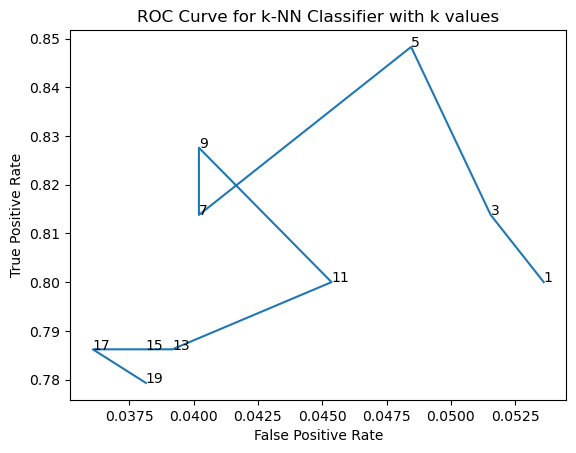

In [48]:
# Set scale to be 1 for both axes
# plt.axis([0, 1, 0, 1])

# Graph the ROC curve with each k value labeled on the curve
plt.plot(false_positive_rates, true_positive_rates)
for i, k in enumerate(num_k):
    plt.text(false_positive_rates[i], true_positive_rates[i], str(k))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for k-NN Classifier with k values')
plt.savefig('roc_curve_with_k_values.png')
plt.show()